# 1. Get the data

## 1.1. Load data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Change working directory
%cd /Users/qing/Google\ Drive/Fall\ 2019/STAT\ 5990\:6690\ Big\ Data\ Analysis\ Using\ Python/Homeworks/Homework\ 5 

/Users/qing/Google Drive/Fall 2019/STAT 5990:6690 Big Data Analysis Using Python/Homeworks/Homework 5


In [3]:
# Load the data
source = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
housing = pd.read_csv('housing.csv') # extra data set 

In [4]:
print(source.shape, test_X.shape, submission.shape, housing.shape)

(18576, 9) (2064, 8) (2064, 2) (20640, 10)


## 1.2. Combine source and test X set to do data cleaning

In [5]:
# Combine feature matrix of source and test to do data cleaning
full = source.append(test_X, ignore_index=True)

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [6]:
full.shape

(20640, 9)

## 1.3. Merge new data set to add attributes

In [7]:
# Add more features to the full data set
housing_sub = housing[['longitude','latitude', 'population','households','ocean_proximity']]
full_mg = full.merge(housing_sub.drop_duplicates(subset=['longitude','latitude', 'population']),
                   left_on=['Longitude','Latitude', 'Population'],
                   right_on=['longitude','latitude', 'population'],
                   how='inner')

In [8]:
full_mg = full_mg.drop(['longitude','latitude', 'population'],axis=1)
full_mg.shape

(20640, 11)

# 2. Discover and visualize the data to gain insights

In [9]:
full_mg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 11 columns):
AveBedrms           20640 non-null float64
AveOccup            20640 non-null float64
AveRooms            20640 non-null float64
CatMedHouseValue    18576 non-null float64
HouseAge            20640 non-null float64
Latitude            20640 non-null float64
Longitude           20640 non-null float64
MedInc              20640 non-null float64
Population          20640 non-null float64
households          20640 non-null float64
ocean_proximity     20640 non-null object
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


## 2.1. Visualize geographical data

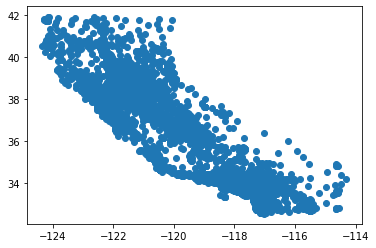

In [10]:
# It looks like a Californian map
plt.scatter(full_mg['Longitude'],full_mg['Latitude'])

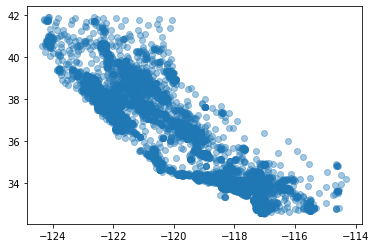

In [11]:
# Add alpha=0.1 to visualize where is a high density of data points
'''
It seems like the high-density areas are Bay-area and around Los 
Angeles and San Diego.
'''
plt.scatter(full_mg['Longitude'], full_mg['Latitude'], alpha=0.4)

## 2.2. Looking for correlations

In [12]:
corr_mat = full_mg.corr()
corr_mat['CatMedHouseValue'].sort_values(ascending=False)

CatMedHouseValue    1.000000
MedInc              0.660428
AveRooms            0.136280
HouseAge            0.096855
households          0.076718
Population         -0.012032
AveOccup           -0.022430
Longitude          -0.045320
AveBedrms          -0.048974
Latitude           -0.146413
Name: CatMedHouseValue, dtype: float64

## 2.3. Experimenting with attribute combinations

Bedrms/Rooms ratio would be an interesting indicator since the lower ratio might imply a high house value due to more office or gyms in houses

In [13]:
full_mg["bedrms_per_room"] = full_mg["AveBedrms"] / full_mg["AveRooms"]

In [14]:
# Check corr matrix again, bedrms_per_room do have a significant impact
# on 'CatMedHouseValue'!
corr_mat = full_mg.corr()
corr_mat['CatMedHouseValue'].sort_values(ascending=False)

CatMedHouseValue    1.000000
MedInc              0.660428
AveRooms            0.136280
HouseAge            0.096855
households          0.076718
Population         -0.012032
AveOccup           -0.022430
Longitude          -0.045320
AveBedrms          -0.048974
Latitude           -0.146413
bedrms_per_room    -0.243639
Name: CatMedHouseValue, dtype: float64

# 3. Prepare the Data for Machine Learning Algorithms

## 3.1. Data cleaning

### 3.1.1. Check missing values

In [15]:
# No missing values for feature matrix
full_mg.isnull().sum()

AveBedrms              0
AveOccup               0
AveRooms               0
CatMedHouseValue    2064
HouseAge               0
Latitude               0
Longitude              0
MedInc                 0
Population             0
households             0
ocean_proximity        0
bedrms_per_room        0
dtype: int64

## 3.2. Handling text and categorical attributes

In [16]:
full_mg['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'ISLAND'],
      dtype=object)

In [17]:
# one-hot coding, drop first dummy to avoid multi-collinearity
proximDf = pd.get_dummies(full_mg['ocean_proximity'],drop_first=True)

In [18]:
proximDf.head()

,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,1,0
1,0,0,1,0
2,0,0,0,0
3,0,0,0,1
4,1,0,0,0


In [19]:
full_mg = pd.concat([full_mg, proximDf], axis=1)

full_mg.drop('ocean_proximity', axis=1, inplace=True)
full_mg.head()

,AveBedrms,AveOccup,AveRooms,CatMedHouseValue,HouseAge,Latitude,Longitude,MedInc,Population,households,bedrms_per_room,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1.100257,2.987147,4.863753,2.0,31.0,37.68,-122.10,3.1250,1162.0,389.0,0.226216,0,0,1,0
1,0.988864,1.955457,3.534521,4.0,52.0,37.86,-122.25,1.7652,878.0,449.0,0.279773,0,0,1,0
2,1.140385,1.634615,4.173077,5.0,22.0,34.07,-118.40,2.9107,850.0,520.0,0.273272,0,0,0,0
3,0.983568,2.772300,4.500000,2.0,34.0,32.75,-117.06,3.0208,1181.0,426.0,0.218571,0,0,0,1
4,1.166384,4.054329,5.665535,1.0,36.0,34.13,-117.27,2.9628,2388.0,589.0,0.205874,1,0,0,0


In [20]:
# Check corr matrix again
corr_mat = full_mg.corr()
corr_mat['CatMedHouseValue'].sort_values(ascending=False)

CatMedHouseValue    1.000000
MedInc              0.660428
NEAR BAY            0.156826
NEAR OCEAN          0.140316
AveRooms            0.136280
HouseAge            0.096855
households          0.076718
ISLAND              0.024019
Population         -0.012032
AveOccup           -0.022430
Longitude          -0.045320
AveBedrms          -0.048974
Latitude           -0.146413
bedrms_per_room    -0.243639
INLAND             -0.484422
Name: CatMedHouseValue, dtype: float64

# 4. Select and train a model

In [21]:
# Split source and test set
sourceRow = 18576
source_mg_X=full_mg.loc[:(sourceRow-1),:].drop("CatMedHouseValue", 
                                               axis=1)
source_mg_y=full_mg.loc[:(sourceRow-1),"CatMedHouseValue"].astype(int)
test_mg_X=full_mg.loc[sourceRow:,:].drop("CatMedHouseValue", 
                                               axis=1)
print(source_mg_X.shape,source_mg_y.shape,test_mg_X.shape)

(18576, 14) (18576,) (2064, 14)


## Model 1: Linear Discriminant Analysis

In [22]:
# model fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(source_mg_X,source_mg_y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
# find train accuracy
lda_pred = lda.predict(source_mg_X)
from sklearn.metrics import accuracy_score
lda_trainacc = accuracy_score(lda_pred,source_mg_y)
lda_trainacc

0.6056739879414298

In [24]:
# find test accuracy through cross-validation (cv)
from sklearn.model_selection import cross_val_score
lda_scores = cross_val_score(lda,source_mg_X,source_mg_y,
                            scoring='accuracy', cv=10)
lda_testacc = np.mean(lda_scores)
lda_testacc

0.6041119548785236

## Model 2: Random Forest
(Note: Ensemble methods usually outperform best individual methods,
like random forest is usually better than the individual decision tree.)

In [25]:
# model fit
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(source_mg_X,source_mg_y)

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
# find train accuracy
forest_pred = forest.predict(source_mg_X)
from sklearn.metrics import accuracy_score
forest_trainacc = accuracy_score(forest_pred,source_mg_y)
forest_trainacc

0.9897179155900087

In [27]:
# find test accuracy through cv
from sklearn.model_selection import cross_val_score
forest_scores = cross_val_score(forest,source_mg_X,source_mg_y,
                               scoring='accuracy',cv=10)
forest_testacc = np.mean(forest_scores)
forest_testacc

0.6913155278864395

## Model 3: XGBoosting

In [28]:
# model fit
import xgboost as xgb
XGb = xgb.XGBClassifier()
XGb.fit(source_mg_X,source_mg_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
# find train accuracy
XGb_pred = XGb.predict(source_mg_X)
from sklearn.metrics import accuracy_score
XGb_trainacc = accuracy_score(XGb_pred,source_mg_y)
XGb_trainacc

0.7104328165374677

In [30]:
# find test accuracy through cv
from sklearn.model_selection import cross_val_score
XGb_scores = cross_val_score(XGb,source_mg_X,source_mg_y,
                               scoring='accuracy',cv=10)
XGb_testacc = np.mean(XGb_scores)
XGb_testacc

0.6864202546564855

## Model 4: Support Vector Machine

In [32]:
#model fit
from sklearn.svm import SVC
svm = SVC()
svm.fit(source_mg_X,source_mg_y)

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [33]:
#find train accuracy
svm_pred = svm.predict(source_mg_X)
from sklearn.metrics import accuracy_score
svm_trainacc = accuracy_score(svm_pred,source_mg_y)
svm_trainacc

0.9953703703703703

In [34]:
#find test accuracy through cv
from sklearn.model_selection import cross_val_score
svm_scores = cross_val_score(svm,source_mg_X,source_mg_y,
                               scoring='accuracy',cv=10)
svm_testacc = np.mean(svm_scores)
svm_testacc

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/qing/opt/anaconda3/lib/python3.7/site-p

0.40035464067692106

## Model 5: Deep Learning

In [35]:
# Import keras models and layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [36]:
# Create model
model = Sequential()

In [37]:
# Get number of columns in training data
n_cols = source_mg_X.shape[1]
n_cols

14

In [38]:
# Define model (one hidden layer with 100 nodes, 50% dropout)
model.add(Dense(100, input_dim = n_cols, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation = "softmax"))

In [39]:
# Compile the model
model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", 
              metrics = ["accuracy"])

In [41]:
# Fit the model on the dataset
from keras.utils import to_categorical
source_y_bi = to_categorical(source_mg_y)[:,1:]

model.fit(source_mg_X, source_y_bi, epochs = 100, batch_size = 16)

Epoch 1/100
18576/18576 [==============================] - 2s 112us/step - loss: 1.3721 - accuracy: 0.4115
Epoch 2/100
18576/18576 [==============================] - 2s 102us/step - loss: 1.3590 - accuracy: 0.4193
Epoch 3/100
18576/18576 [==============================] - 2s 120us/step - loss: 1.3549 - accuracy: 0.42290s - loss: 1.3530 
Epoch 4/100
18576/18576 [==============================] - 2s 127us/step - loss: 1.3569 - accuracy: 0.4215
Epoch 5/100
18576/18576 [==============================] - 3s 177us/step - loss: 1.3620 - accuracy: 0.4217
Epoch 6/100
18576/18576 [==============================] - 3s 184us/step - loss: 1.3661 - accuracy: 0.41930s - loss: 1.362
Epoch 7/100
18576/18576 [==============================] - 4s 222us/step - loss: 1.3624 - accuracy: 0.4220
Epoch 8/100
18576/18576 [==============================] - 4s 189us/step - loss: 1.3538 - accuracy: 0.4229
Epoch 9/100
18576/18576 [==============================] - 3s 153us/step - loss: 1.3533 - accuracy: 0.4268
Epo

/Users/qing/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110136). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


18576/18576 [==============================] - 3s 171us/step - loss: 1.3524 - accuracy: 0.42621s - loss: 1
Epoch 33/100
18576/18576 [==============================] - 2s 99us/step - loss: 1.3275 - accuracy: 0.4266
Epoch 34/100
18576/18576 [==============================] - 2s 115us/step - loss: 1.3189 - accuracy: 0.4226
Epoch 35/100
18576/18576 [==============================] - 2s 101us/step - loss: 1.3020 - accuracy: 0.4215
Epoch 36/100
18576/18576 [==============================] - 2s 90us/step - loss: 1.2978 - accuracy: 0.4218 0s - loss: 1.306
Epoch 37/100
18576/18576 [==============================] - 2s 92us/step - loss: 1.3025 - accuracy: 0.4199
Epoch 38/100
18576/18576 [==============================] - 2s 112us/step - loss: 1.2943 - accuracy: 0.4224
Epoch 39/100
18576/18576 [==============================] - 2s 90us/step - loss: 1.2901 - accuracy: 0.4209
Epoch 40/100
18576/18576 [==============================] - 2s 89us/step - loss: 1.2934 - accuracy: 0.4220
Epoch 41/100
1857

In [42]:
source_y_bi.shape

(18576, 5)

In [43]:
pd.DataFrame(source_y_bi).head()

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [44]:
# Evaluate the model
model.evaluate(source_mg_X,source_y_bi)

18576/18576 [==============================] - 1s 29us/step


[1.1943817276260547, 0.4038544297218323]

# 5. Hyperparameter Tuning

Based on the accuracy results above, we would choose Random Forest and XGBoost to do hyperparameter tuning.

## 5.1. Random Forest

### 5.1.1. Grid search

In [45]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [30, 50, 100], 'max_features': [2, 4, 6, "auto"]}
]
forest_grid_search=GridSearchCV(forest, param_grid, cv=5, 
                                scoring='accuracy')
forest_grid_search.fit(source_mg_X,source_mg_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [46]:
forest_grid_search.best_params_

{'max_features': 4, 'n_estimators': 100}

In [47]:
cvres = forest_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
    print(mean_score, params)

0.7061800172265289 {'max_features': 2, 'n_estimators': 30}
0.7143626184323859 {'max_features': 2, 'n_estimators': 50}
0.7199612403100775 {'max_features': 2, 'n_estimators': 100}
0.7172157622739018 {'max_features': 4, 'n_estimators': 30}
0.720230404823428 {'max_features': 4, 'n_estimators': 50}
0.7257751937984496 {'max_features': 4, 'n_estimators': 100}
0.7159237726098191 {'max_features': 6, 'n_estimators': 30}
0.7190999138673557 {'max_features': 6, 'n_estimators': 50}
0.7237833763996555 {'max_features': 6, 'n_estimators': 100}
0.7138781223083549 {'max_features': 'auto', 'n_estimators': 30}
0.717323428079242 {'max_features': 'auto', 'n_estimators': 50}
0.7220068906115418 {'max_features': 'auto', 'n_estimators': 100}


### 5.1.3. Submission 1

In [48]:
forest_final = RandomForestClassifier(max_features = 4, n_estimators = 100)
forest_final.fit(source_mg_X,source_mg_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
pred_y = forest_final.predict(test_mg_X)
submission["Prediction"] = pred_y.astype(int)
submission.to_csv("CatMedHouseValue_pred.csv", index=False)

In [50]:
submission.head()

,Id,Prediction
0,2834,1
1,19200,2
2,5325,5
3,7650,3
4,10452,3


## 5.2. XGBoost

### 5.2.1. Grid search

In [51]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
XGb = xgb.XGBClassifier(objective = "multi:softprob")
parameters = {'max_depth': [2,3,4,5], 'n_estimators': [50,100,150,200]}
XGB_grid_search = GridSearchCV(XGb, parameters, cv = 10)
XGB_grid_search.fit(source_mg_X,source_mg_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='multi:softprob',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, re

In [52]:
print(XGB_grid_search.best_params_)
print(XGB_grid_search.best_score_)

{'max_depth': 5, 'n_estimators': 200}
0.7394487510766581


### 5.3.2. Submission 2

In [53]:
XGb_final = xgb.XGBClassifier(
    objective = "multi:softprob",
    max_depth = 5,
    n_estimators = 200,
    n_jobs=3
)

In [54]:
XGb_final.fit(source_mg_X,source_mg_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=3,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [55]:
pred_y = XGb_final.predict(test_mg_X)
#submission["Prediction"] = pred_y.astype(int)
#submission.to_csv("CatMedHouseValue_pred.csv", index=False)

In [56]:
submission.head()

,Id,Prediction
0,2834,1
1,19200,2
2,5325,5
3,7650,3
4,10452,3
